### Carga de datos

In [38]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
%matplotlib inline
plt.style.use('default')
sns.set()

In [40]:
#Funciones auxiliares
def mostrar_porcentaje_barplot(ax):
    suma = 0
    for p in ax.patches:
        suma += p.get_height()
    for p in ax.patches:
        ax.annotate(str(np.round(100 *(p.get_height() / suma),decimals=2)) + "%", (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
def mostrar_valores_barplot(ax):
    for p in ax.patches:
        ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

In [41]:
#Cargo el DataFrame
df = pd.read_csv('events.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})

## Leads

In [42]:
leads = df.loc[df['event'] == 'lead', ['timestamp', 'person', 'model']].copy()
conversions = df.loc[df['event'] == 'conversion', ['timestamp', 'person', 'model']]
checkouts = df.loc[df['event'] == 'checkout', ['timestamp', 'person', 'model']]

### Cantidad de leads

In [43]:
len(leads['timestamp'])

448

Hubo 380 solicitudes de notificacion de stock

### Cantidad de usuarios que solicitaron notificacion de stock

In [44]:
len(leads['person'].unique())

291

291 usuarios solicitaron notificacion por faltante de stock

In [45]:
len(conversions['person'].unique())

716

716 usuarios realizaron al menos una conversion

### Leads semanales

Text(0.5,1,'Solicitudes de stock semanales')

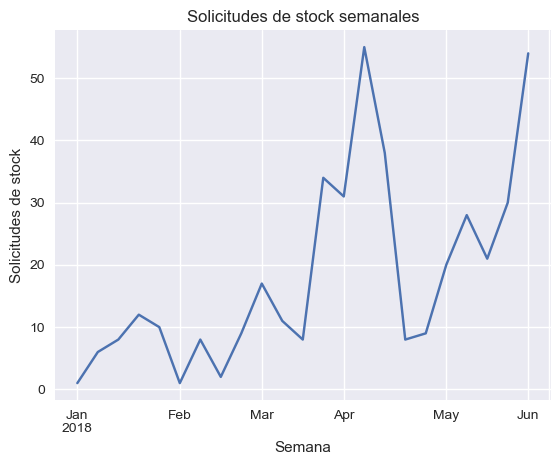

In [58]:
leads_by_week = leads.loc[:, ['timestamp']].copy()
leads_by_week['semana'] = leads_by_week['timestamp'].dt.week - 1
leads_by_week = leads_by_week[leads_by_week['semana'] != leads_by_week['semana'].max()] #Borro la ultima semana incompleta
leads_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(leads_by_week['semana'].mul(7).astype('str') + ' days')

leads_weeks = leads_by_week['semana'].value_counts().to_frame().sort_index()
ax = leads_weeks['semana'].plot()
ax.set(xlabel='Semana', ylabel='Solicitudes de stock')
ax.set_title('Solicitudes de stock semanales')

In [55]:
leads_weeks['semana'].iloc[-11:].mean()

29.818181818181817

Hay un promedio de 30 leads semanales desde abril.

### Relacion leads y conversiones

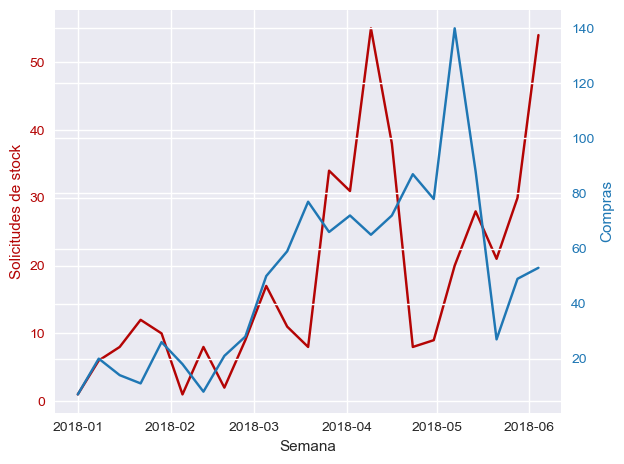

In [59]:
conversions_by_week = conversions.loc[:, ['timestamp']].copy()
conversions_by_week['semana'] = conversions_by_week['timestamp'].dt.week - 1
conversions_by_week = conversions_by_week[conversions_by_week['semana'] != conversions_by_week['semana'].max()] #Borro la ultima semana incompleta
conversions_by_week['semana'] = pd.to_datetime('2018', format='%Y') + pd.to_timedelta(conversions_by_week['semana'].mul(7).astype('str') + ' days')
conversions_weeks = conversions_by_week['semana'].value_counts().to_frame().sort_index()

fig, ax1 = plt.subplots()

color='#B40404'
ax1.set_xlabel('Semana')
ax1.set_ylabel('Solicitudes de stock', color=color)
ax1.plot(leads_weeks['semana'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Compras', color=color)
ax2.plot(conversions_weeks['semana'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

Notamos que en los momentos en que mas solicitudes de stock hay, las conversiones se estancan o disminuyen

### ¿Que marcas tienen mas solicitudes de notificacion de stock?

In [48]:
def obtener_marca(serie_de_modelo):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(modelo.split()[0])
    return r

In [49]:
leads['marca'] = obtener_marca(leads['model'])
leads['semana'] = leads['timestamp'].dt.week
conversions['marca'] = obtener_marca(conversions['model'])

leads_unicos = leads.drop_duplicates(subset = ['person', 'model', 'semana'])

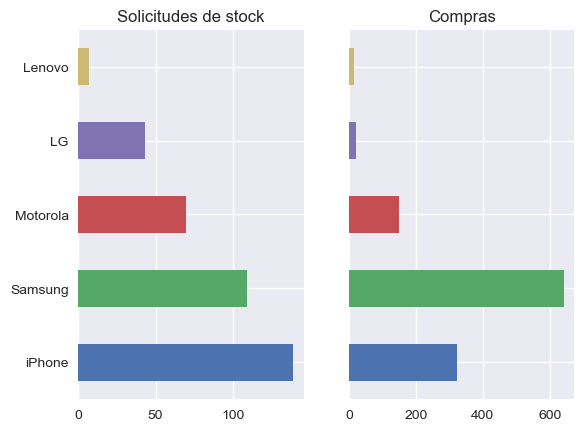

In [56]:
leads_count = leads_unicos['marca'].value_counts().to_frame()
conversions_count = conversions['marca'].value_counts().to_frame()
count = pd.concat([leads_count, conversions_count], axis=1, join_axes=[leads_count.index])
count.columns = ['leads','conversiones']
count = count.iloc[0:5]

fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)

ax.yaxis.tick_left()

count['leads'].plot(kind='barh', x='LABEL',  legend=False, ax=ax)
count['conversiones'].plot(kind='barh', x='LABEL',ax=ax2)
ax.set_title('Solicitudes de stock')
ax2.set_title('Compras')
plt.show()

Vemos que los iphone son los que mayor cantidad de leads tienen y los Samsung quedan en segundo lugar, pero la cantidad de Samsung vendidos es el doble que la cantidad de iphones vendidos, lo que significa que hay un problema de stock para los iphone. Tambien para los LG hay una cantidad grande de lead en comparacion con sus conversiones.

### ¿Cuantos de esos lead se convirtieron en compra?

Text(0,0.5,'')

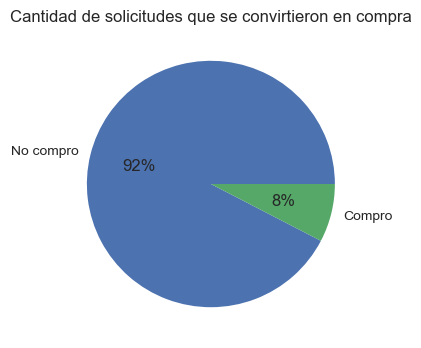

In [70]:
leads_red = leads_unicos[['person', 'model']]
conversions_red = conversions[['person', 'model']].copy()
conversions_red['conversion'] = True

leads_red = leads_red.merge(conversions_red.drop_duplicates(), on = ['person', 'model'], how = 'left')
valores = leads_red['conversion'].fillna(False).value_counts()
valores.rename({False:'No compro', True:'Compro'}, inplace=True)
ax = valores.plot('pie', autopct='%1.0f%%', figsize=(4,4), title='Cantidad de solicitudes que se convirtieron en compra')
ax.set_ylabel('')

Solamente 29 de los 380 leads unicos (sin contar multiples lead de un mismo usuario para un mismo modelo en una misma semana) se convirtieron en compra, un numero desalentador considerando que son 351 potenciales compras que no pudieron realizarse por faltante de stock.